## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Столбец date имеет формат object

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [5]:
# приведем столбец date к типу данных datetime
data['date'] = pd.to_datetime(data['date'])

# сгруппируем таблицу по группам и выведем даны начала и конца наблюдения
data.groupby('group')['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [17]:
# найдем количество посещений
display(data.groupby('group')['user_id'].count())

# найдем количество покупок
display(data.groupby('group')['purchase'].sum())

# найдем сумму покупок в группах 
# (так как каждая запись содержит в себе не больще одной покупки - можем взять сумму по полю price)
display(data.groupby('group')['price'].sum()/1000000)

group
A    147202
B    147276
Name: user_id, dtype: int64

group
A    17723
B    17514
Name: purchase, dtype: int64

group
A    1436.26
B    1554.10
Name: price, dtype: float64

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [20]:
# создадим множества пользователей A и B
a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']

# найдем перечекающихся пользователей
user_intersection = set(a_data['user_id']).intersection(set(b_data['user_id']))

# выведем количество пересекающихся пользователей
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [21]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

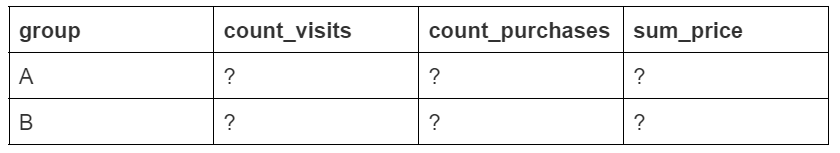
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [25]:
# сгруппируем данные по группе с агрегатором функций
gr_data = updated_data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})

# переименуем столбцы
gr_data = gr_data.rename(columns={'user_id':'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

### Промежуточные выводы по построенной таблице
- Количество посещений в группах отличается незначительно (расхождение на уровне 0.05%).
- Выборки достаточно сбалансированные для анализа.
- Количество покупок больше в группе А, а стоимость покупок выше в группе B. Т.о., получается, что пользователи в группе А делают покупки чаще, но выбирают более дешевые товары. И наоборот: пользователи из группы B покупают немногим реже, но более дорогие товары.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [31]:
# добавим необходимые столбцы в таблицу
gr_data['conversion'] = round(gr_data['count_purchases'] / gr_data['count_visits'] * 100,2)
gr_data['mean_check'] = round(gr_data['sum_price'] / gr_data['count_purchases'])

# выведем таблицу на экран для ответа на вопросы
gr_data

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

### Промежуточные выводы по таблице
Теперь более наглядно показаны различия в результатах в двух группах:
- Конверсия несколько выше в группе А
- Средний чек выше в группе B

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [35]:
# построим сводную таблицу
pivot_data = updated_data.pivot_table(index = 'group',
                                      columns = 'price',
                                      values = 'purchase',
                                      aggfunc = 'sum')

# выведем полученную таблицу на жкран
display(pivot_data)

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

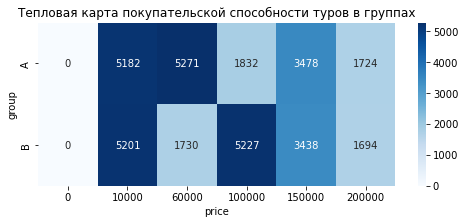

In [69]:
fig = plt.figure(figsize=(8, 3))
ax = sns.heatmap(pivot_data, fmt='0.0f', annot=True, cmap='Blues');
ax.set_title('Тепловая карта покупательской способности туров в группах');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

### Выводы по таблице
- Суммарно по двум группам наиболее популярными являются туры с ценой 10 000: обе группы показали одинаково высокий результат.
- Сравнимый высокий резльтат группа А продемонстрировала в турах за 60 000, а группа B - в турах за 100 000.
- Группы демонстрируют практически равный результат по турам за 150 000, схожая картина наблюдается и по турам за 200 000.

Т.о. видно, что результаты групп различаются по турам за 60 000 и 100 000. При этом в группе А предпочитают туры за 60 000, а в группе B примерно такое же количество покупателей приобрело туры уже за 100 000. Это и объясняет сделанный ранее вывод о более высоком среднем чеке в группе B.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [87]:
# сгруппируем данные по дате и группе
daily_data = updated_data.groupby(['date', 'group']).agg({'user_id':'count', 'purchase':'sum', 'price': 'sum'}).reset_index()

# преименуем столбцы
daily_data = daily_data.rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

# добавим в таблицу информацию о ежедневной конверсии и среднем чеке
daily_data['conversion'] = daily_data['count_purchases'] / daily_data['count_visits'] * 100
daily_data['mean_check'] = daily_data['sum_price'] / daily_data['count_purchases']

# выведем шапку таблицы дял ответа на вопрос
daily_data.head()

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [97]:
# добавим необходимые кумулятивные признаки
daily_data['cum_count_visits'] = daily_data.groupby('group')['count_visits'].cumsum()
daily_data['cum_count_purchases'] = daily_data.groupby('group')['count_purchases'].cumsum()
daily_data['cum_sum_price'] = daily_data.groupby('group')['sum_price'].cumsum()

# рассчитаем кумулятивную конверсию и средний чек
daily_data['cum_conversion'] = daily_data['cum_count_purchases'] / daily_data['cum_count_visits'] * 100
daily_data['cum_mean_check'] = daily_data['cum_sum_price'] / daily_data['cum_count_purchases']

# ответим на вопросы
display(daily_data[(daily_data['date'] == '2021-01-20') & (daily_data['group'] == 'B')]['cum_conversion'])
display(daily_data[(daily_data['date'] == '2021-01-12') & (daily_data['group'] == 'A')]['cum_mean_check'])

37    11.895911
Name: cum_conversion, dtype: float64

20    81491.827275
Name: cum_mean_check, dtype: float64

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

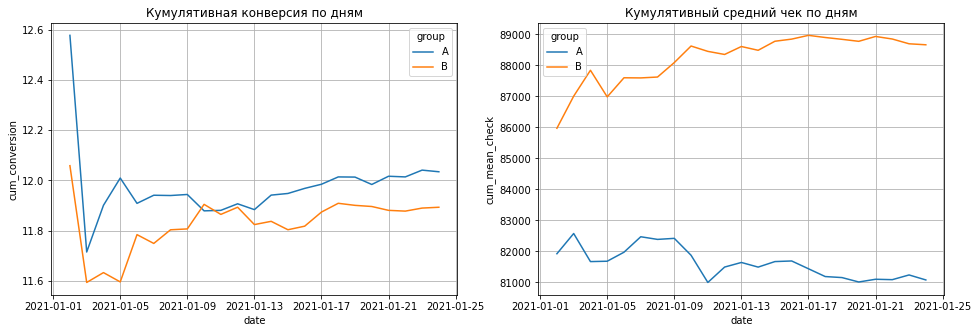

In [114]:
fig, axes= plt.subplots(1, 2, figsize=(16, 5))
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=axes[0])
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=axes[1])
axes[0].set_title('Кумулятивная конверсия по дням')
axes[1].set_title('Кумулятивный средний чек по дням')
axes[0].grid(True);
axes[1].grid(True);

### Выводы по кумулятивным графикам
- Кумулятивная конверсия в группе А на всем протяжении измерений была выше группы B, кроме одного дня - 10 января. С течением времени (начиная с 13 января) соотношение групп стабилизировалось.
- Кумулятивный средний чек в группе B стабильно выше группы А на всем протяжени измерений.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [115]:
# проведем z-тест для конверсии
converted_piv= data.groupby('group')['purchase'].agg(['sum', 'count'])

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.11
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

### Выводы по результатам z-теста
Z-тест показал, что значения конверсий в группах равны (с уровнем значимости 0.05), полученная разница в метрике в группах статистически не значима.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [117]:
def conversion_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

n_a = updated_data[updated_data['group'] == 'A']['user_id'].count() # размеры выборки группы А
xp_a = updated_data[updated_data['group'] == 'A']['purchase'].mean() # выборочная пропорция группы A
n_b = updated_data[updated_data['group'] == 'B']['user_id'].count() # размеры выборки группы B
xp_b = updated_data[updated_data['group'] == 'B']['purchase'].mean() # выборочная пропорция группы B

conf_interval_a = conversion_conf_interval(n_a, xp_a)
conf_interval_b = conversion_conf_interval(n_b, xp_b)

print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

def diff_conversion_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [updated_data[updated_data['group'] == 'A']['user_id'].count(), updated_data[updated_data['group'] == 'B']['user_id'].count()]
# выборочная пропорция групп A и B
xp = [updated_data[updated_data['group'] == 'A']['purchase'].mean(), updated_data[updated_data['group'] == 'B']['purchase'].mean()]

# доверительный интервал для разности конверсий
diff_inverval = diff_conversion_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

### Выводы по доверительным интервалам конверсий
- С надёжностью в 95% конверсия группы А лежит в интервале от 11.87% до 12.12%, а конверсия группы B лежит в интервале от 11.73% до 12.06%.
- Пересечение интервалов означает, что существует вероятность того, что истинное значение конверсии в обеих группах может совпасть и будет невозможно однозначно сказать, есть ли разница в конверсиях.
- Доверительный интервал для разности конверсий с надёжностью в 95% показывает, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38% до 0.09%.
- Т.о., статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [119]:
# формулируем гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
 
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']
 
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data_a['mean_check'])
shapiro_result_b = shapiro(daily_data_b['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [120]:
# формулируем гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
 
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']
 
#вычисляем результат T-теста для выборок
results = ttest_ind(
    daily_data_a['mean_check'],
    daily_data_b['mean_check'],
    alternative='less')
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

### Выводы по результатам T-теста
- Полученное значение p-value 0 (<0.05) - значит, мы отвергаем нулевую гипотезу в пользу альтернативной: ежедневный средний чек в группе А меньше чем в группе B.
- Отсюда можно сделать вывод, что что новый вариант дизайна страницы более привлекателен для посетителей, чем старый - по данной метрике.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [121]:
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    return round(lower_bound), round(upper_bound)
 
mean_check_interval_a = mean_check_conf_interval(daily_data[daily_data['group'] == 'A']['count_visits'].count(), 
                                                 daily_data[daily_data['group'] == 'A']['mean_check'].mean(),
                                                 daily_data[daily_data['group'] == 'A']['mean_check'].std())

mean_check_interval_b = mean_check_conf_interval(daily_data[daily_data['group'] == 'B']['count_visits'].count(), 
                                                 daily_data[daily_data['group'] == 'B']['mean_check'].mean(),
                                                 daily_data[daily_data['group'] == 'B']['mean_check'].std())
 
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_interval_a)) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_interval_b))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

### Выводы по доверительным интервалам для средних чеков
- С надёжностью в 95% средний чек группы А находится в интервале от 79 630 до 82 308, а средний чек группы B находится в интервале от 87 626 до 89 526.
- Пересечения интервалов нет - значит истинное значение средних чеков группы B выше, чем группы А.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

### Выводы по результатам А/B теста
- Конверсия: Статистической разницы между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.
- Средний чек: Истинное значение средних чеков группы B выше, чем группы А.

Т.о., можно сделать вывод, что новый вариант дизайна страницы более привлекателен для посетителей, чем старый.